In [5]:
library(rstan)
library(coda)

Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: ‘coda’


The following object is masked from ‘package:rstan’:

    traceplot




In [6]:
options(mc.cores = parallel :: detectCores ())
parallel :: detectCores ()
rstan_options(auto_write = TRUE)

[1] 20

## Tentativo per auronzo minimo

In [28]:
modelString = "
    data {
        int<lower=0> N;
        vector[N] date;
        vector[N] temp;
    }
    parameters {
        real m;
        real q;
        real<lower=0> sigma;
        real m_mean;
        real m_sd;
        real q_mean;
        real q_sd;
    }
    model {
        m ~ normal(m_mean, m_sd);
        q ~ normal(q_mean, q_sd);
        sigma ~ exponential(1); ##suggerito da chat
        #sigma ~ uniform(0,0.1); ## meno informativa? 
        temp ~ normal(m*(date)+q,sigma);
    }"
writeLines ( modelString , con="stan_arpav_v0.txt")

In [29]:
stanDso <- stan_model(model_code = modelString )

In [30]:
df_aur<-df_long[df_long$paese == 'Auronzo', ]
df_aur$data_numerico <- as.numeric(format(df_aur$data, "%Y")) + 
                    (as.numeric(format(df_aur$data, "%m")) - 1) / 12
df_aur_min<-df_aur[df_aur$tipo == 'min', ]


Warning message:
“There were 7 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 2563 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 2.06, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles ma

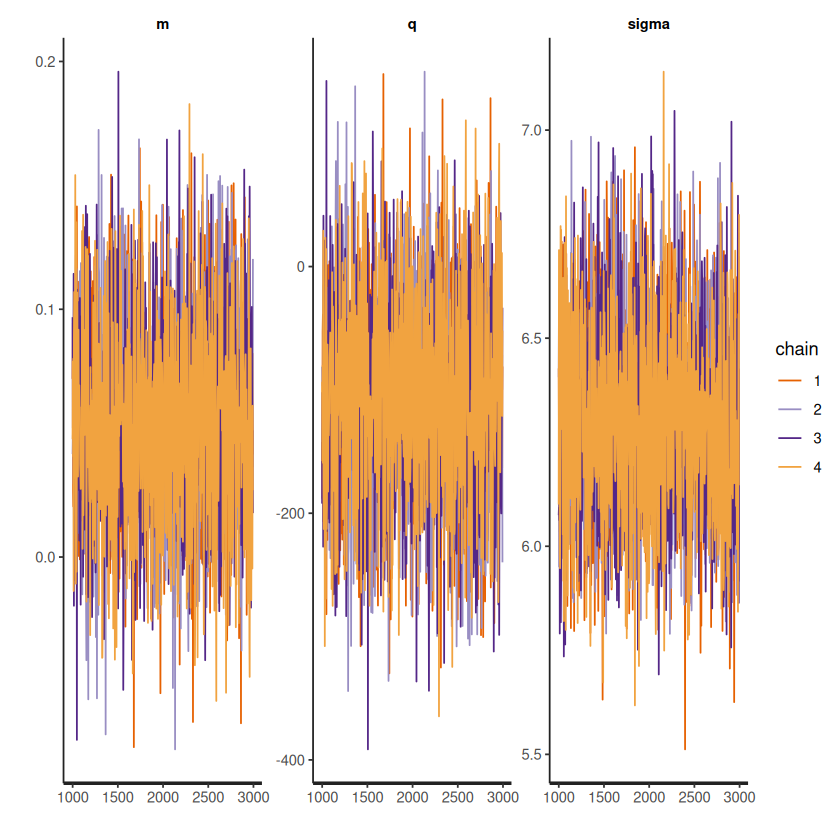

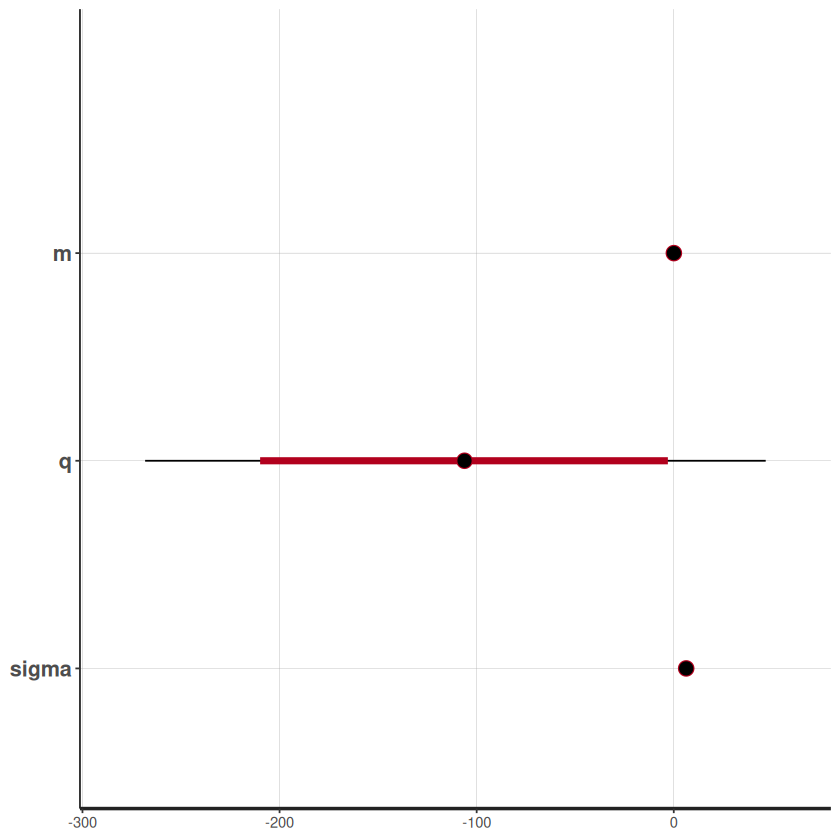

In [38]:
dataList <- list(
    N = nrow(df_aur_min),
    date = df_aur_min$data_numerico,
    temp = df_aur_min$temperatura,
    m_mean=0.04936,
    m_sd=0.005,
    q_mean=-97,  ##le sd non so da dove prenderle?
    q_sd=10
)

stanFit <- sampling(
    object = stanDso,
    data = dataList,
    chains = 4,
    iter = 3000,     
    warmup = 1000,     
    thin = 3,
    #control = list(max_treedepth = 15, adapt_delta = 0.95)  # non necessario, ma altrimenti dà un warning
)                                                           # allunga parecchio il sampling, commentare per fare prima 

rstan :: traceplot(stanFit ,pars=c('m','q','sigma'))
plot(stanFit ,pars=c('m','q','sigma'))
results <- mcmc.list(lapply(1:ncol(stanFit),
                    function(x) {mcmc(as.array(stanFit )[,x ,])}))



In [39]:
summary(results)


Iterations = 1:667
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 667 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean        SD  Naive SE Time-series SE
m       5.390e-02 3.970e-02 7.686e-04      8.248e-04
q      -1.062e+02 7.974e+01 1.544e+00      1.657e+00
sigma   6.306e+00 2.298e-01 4.449e-03      4.475e-03
m_mean -4.043e+04 1.540e+05 2.981e+03      6.754e+04
m_sd    9.408e+04 1.393e+05 2.697e+03      2.589e+04
q_mean -6.666e+04 9.813e+04 1.900e+03      1.863e+04
q_sd    1.019e+05 1.123e+05 2.174e+03      1.773e+04
lp__   -8.705e+02 4.072e+00 7.884e-02      2.378e-01

2. Quantiles for each variable:

             2.5%        25%        50%        75%      97.5%
m      -2.205e-02  2.768e-02  5.362e-02  7.889e-02  1.345e-01
q      -2.682e+02 -1.564e+02 -1.060e+02 -5.374e+01  4.652e+01
sigma   5.869e+00  6.150e+00  6.300e+00  6.452e+00  6.773e+00
m_mean -5.503e+05 -2.431e+04 -3.556e+03  1.694e+0